### 1. Setup and Data Preprocessing

In [ ]:
!pip install mxnet
!pip install d2l
!pip install numpy==1.23

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
bigframes 1.27.0 requires numpy>=1.24.0, but you have numpy 1.23.0 which is incompatible.
chex 0.1.87 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
d2l 1.0.3 requires numpy==1.23.5, but you have numpy 1.23.0 which is incompatible.
ibis-framework 9.2.0 requires nu

In [ ]:
# Import necessary packages
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
import pandas as pd

npx.set_np()

In [ ]:
# Load and unzip the amazon-product-reviews.zip file
!kaggle datasets download -d saurav9786/amazon-product-reviews
!unzip amazon-product-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews
License(s): unknown
amazon-product-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-product-reviews.zip
replace ratings_Electronics (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Load the ratings_Electronics (1).csv dataset
data = pd.read_csv('/content/ratings_Electronics (1).csv')

In [ ]:
# Data Cleaning
data.columns = ['user_id', 'item_id', 'rating', 'timestamp']
#data = data.drop(columns=['timestamp'])
data.head()

num_users = data.user_id.unique().shape[0]
num_items = data.item_id.unique().shape[0]

In [ ]:
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [ ]:
# splitting and loading

def split_data(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data


In [ ]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [ ]:

    def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

IndentationError: expected an indented block after function definition on line 1 (<ipython-input-24-b8ca669ca3cf>, line 3)

### 2. Basline Model: SVD

In [ ]:
# !pip install scikit-surprise
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

# create train, test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Instantiate the SVD model
svd = SVD()

# Train the model on the training set
svd.fit(trainset)

# Predict ratings for the test set
predictions = svd.test(testset)

# Compute and print RMSE and MAE
from surprise import accuracy
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.2943
MAE:  1.0190


In [ ]:
import csv
with open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

### 3. Model Implementation

In [ ]:
# Model Implementations
class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

In [ ]:
# Evaluation Measures
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

In [ ]:
# Training and evaluating the model
def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            train_feat = input_data[:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

ZeroDivisionError: integer division or modulo by zero

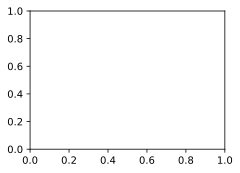

In [ ]:
# Training
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

### 3.1 Alernative method with pytorch

In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load and unzip the amazon-product-reviews.zip file
!kaggle datasets download -d saurav9786/amazon-product-reviews
!unzip amazon-product-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews
License(s): unknown
 83% 91.0M/109M [00:01<00:00, 73.9MB/s]
100% 109M/109M [00:01<00:00, 77.3MB/s] 
Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


In [ ]:
# Load the ratings_Electronics (1).csv dataset
df = pd.read_csv('/content/ratings_Electronics (1).csv')

In [ ]:
# Data Cleaning
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df.sort_values(['user_id', 'timestamp'], ascending=[True, True]).reset_index(drop=True)
df.head()

,user_id,item_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
# Change the id of items and users so that max_id = n_users/n_items
d = defaultdict(LabelEncoder)
cols_cat = ['user_id', 'item_id']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
df.head()

,user_id,item_id,rating,timestamp
0,1512496,0,5.0,1341100800
1,1850798,1,1.0,1367193600
2,2118940,1,3.0,1374451200
3,511952,1,1.0,1334707200
4,819547,2,5.0,1397433600


In [ ]:
# Train test split, use the first 5 reviews of each user as validation set
df_train = df.groupby('user_id').head(-5).reset_index(drop=True)
df_val = df.groupby('user_id').tail(5).reset_index(drop=True)

class ItemDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['user_id', 'item_id', 'rating']]
        self.x_user_item = list(zip(df.user_id.values, df.item_id.values))
        self.y_rating = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_user_item[idx], self.y_rating[idx]

In [ ]:
BS = 8192
ds_train = ItemDataset(df_train)
ds_val = ItemDataset(df_val)
dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=2)
dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=2)

xb, yb = next(iter(dl_train))
print(xb)
print(yb)

[tensor([ 586445, 1810496,  112235,  ..., 3411969, 2522441,  449602]), tensor([145465,  42718,   7505,  ...,   5144,  80397, 141366])]
tensor([2., 4., 5.,  ..., 5., 5., 3.], dtype=torch.float64)


In [ ]:
class MF(nn.Module):
    """ Matrix factorization model simple """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        return element_product

In [ ]:
n_users = len(df.user_id.unique())
n_items = len(df.item_id.unique())
mdl = MF(n_users, n_items, emb_dim=32)
mdl.to(device)
print(mdl)

MF(
  (user_emb): Embedding(4201696, 32)
  (item_emb): Embedding(476001, 32)
)


In [ ]:
LR = 0.2
NUM_EPOCHS = 10

opt = optim.AdamW(mdl.parameters(), lr=LR)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    mdl.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 81.9, Val Loss:63.4
